# Проект "Анализ локаций для бурения нефтяных скважин"

**Заказчик:** компания «ГлавРосГосНефть» (далее - Заказчик).

**Цели проекта:** 
- Произвести анализ характеристик проб нефти из скважин в Регионах 1,2,3 (входные признаки: f0, f1, f2, таргет: "product" — объём запасов в скважине (тыс. баррелей).
- Построить модель машинного обучения (далее - МО) для предсказания объёма запаса нефти в новых скважинах по каждому региону.
- Выбрать скважины с самой высокой оценкой значений.
- Определить регион с максимальной суммарной прибылью отобранных скважин.
- Проанализировать возможную прибыль и риски техникой Bootstrap.
- Выдать рекомендации Заказчику касательно региона для дальнейшей разработки.

Исходные данные:
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

## 0. Подготовка ноутбука к работе

Импорты

In [43]:
pip install -q phik

Note: you may need to restart the kernel to use updated packages.


In [44]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and evaluation
from sklearn.model_selection import train_test_split 

# Machine learning models
from sklearn.linear_model import LinearRegression

# Model evaluation metrics
from sklearn.metrics import root_mean_squared_error

# Additional tools
from phik import phik_matrix

Функции и константы

In [45]:
# Display Main Info

def display_main_info (df):
    """
    Display basic information about the DataFrame.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - None
    """

    print("\n------ DataFrame Shape ------")
    display(df.shape)

    print("\n------ DataFrame Info ------")
    display(df.info())

    print("------ DataFrame Head ------")
    display(df.head())

    print("------ Percentage of Missing values ------")
    display(df.isna().sum()/len(df)*100)

    print("------ Duplicates ------")
    display(df.duplicated().sum())

    print("------ Duplicates in ID ------")
    display(len(df.index[df.index.duplicated()]))
    return None

In [46]:
# Density Plot & Box Plot 
def plot_density_and_boxplot(data, column):
    """
    Plot density plot and boxplot for a given column in a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - column: str

    Returns:
    - None
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot density plot
    sns.histplot(data[column], bins=50, color='lightgreen', kde=True, ax=axs[0])
    axs[0].set_title(f'Density Plot of {column}')

    # Plot boxplot
    axs[1].boxplot(data[column], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    axs[1].set_title(f'Boxplot of {column}')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

In [47]:
# Constants
RANDOM_STATE = 0

# Float Format
pd.options.display.float_format = '{:,.2f}'.format

## 1. Загрузка данных

In [48]:
# Данные по скважинам Региона 1
df_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv', index_col='id')

In [49]:
df_1.head()

,f0,f1,f2,product
id,,,,
txEyH,0.71,-0.50,1.22,105.28
2acmU,1.33,-0.34,4.37,73.04
409Wp,1.02,0.15,1.42,85.27
iJLyR,-0.03,0.14,2.98,168.62
Xdl7t,1.99,0.16,4.75,154.04


In [50]:
# Данные по скважинам Региона 2
df_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv', index_col='id')

In [51]:
df_2.head()

,f0,f1,f2,product
id,,,,
kBEdx,-15.00,-8.28,-0.01,3.18
62mP7,14.27,-3.48,1.00,26.95
vyE1P,6.26,-5.95,5.00,134.77
KcrkZ,-13.08,-11.51,5.00,137.95
AHL4O,12.70,-8.15,5.00,134.77


In [52]:
# Данные по скважинам Региона 3
df_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv', index_col='id')

In [53]:
df_3.head()

,f0,f1,f2,product
id,,,,
fwXo0,-1.15,0.96,-0.83,27.76
WJtFt,0.26,0.27,-2.53,56.07
ovLUW,0.19,0.29,-5.59,62.87
q6cA6,2.24,-0.55,0.93,114.57
WPMUX,-0.52,1.72,5.90,149.60


## 2. EDA

### 2.1 Общая информация

In [54]:
# Общая информация по скважинам Региона 1
display_main_info(df_1)


------ DataFrame Shape ------


(100000, 4)


------ DataFrame Info ------
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

------ DataFrame Head ------


,f0,f1,f2,product
id,,,,
txEyH,0.71,-0.50,1.22,105.28
2acmU,1.33,-0.34,4.37,73.04
409Wp,1.02,0.15,1.42,85.27
iJLyR,-0.03,0.14,2.98,168.62
Xdl7t,1.99,0.16,4.75,154.04


------ Percentage of Missing values ------


f0        0.00
f1        0.00
f2        0.00
product   0.00
dtype: float64

------ Duplicates ------


0

------ Duplicates in ID ------


10

In [55]:
# Общая информация по скважинам Региона 2
display_main_info(df_2)


------ DataFrame Shape ------


(100000, 4)


------ DataFrame Info ------
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

------ DataFrame Head ------


,f0,f1,f2,product
id,,,,
kBEdx,-15.00,-8.28,-0.01,3.18
62mP7,14.27,-3.48,1.00,26.95
vyE1P,6.26,-5.95,5.00,134.77
KcrkZ,-13.08,-11.51,5.00,137.95
AHL4O,12.70,-8.15,5.00,134.77


------ Percentage of Missing values ------


f0        0.00
f1        0.00
f2        0.00
product   0.00
dtype: float64

------ Duplicates ------


0

------ Duplicates in ID ------


4

In [56]:
# Общая информация по скважинам Региона 3
display_main_info(df_3)


------ DataFrame Shape ------


(100000, 4)


------ DataFrame Info ------
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

------ DataFrame Head ------


,f0,f1,f2,product
id,,,,
fwXo0,-1.15,0.96,-0.83,27.76
WJtFt,0.26,0.27,-2.53,56.07
ovLUW,0.19,0.29,-5.59,62.87
q6cA6,2.24,-0.55,0.93,114.57
WPMUX,-0.52,1.72,5.90,149.60


------ Percentage of Missing values ------


f0        0.00
f1        0.00
f2        0.00
product   0.00
dtype: float64

------ Duplicates ------


0

------ Duplicates in ID ------


4

- Датасеты по каждой скважине содержат 3 одинаковых входных признака и одинаковое их количество.
- Типы данных указаны корректно.
- Пропусков в данных нет.
- Полных дубликатов в данных нет, однако, обнаружены дублирующиеся уникальные идентификаторы скважин.

Нельзя утверждать, что дубликаты по id говорят об ошибке в данных. Данные подготовлены Заказчиком, поэтому такие дубликаты не подлежат удалению. Однако, стоит обратить внимание Заказчика на то, что в данных могут быть неточности.

### 2.2 Статистический анализ

In [57]:
# Статистический анализ Региона 1
df_1.describe()

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


In [58]:
# Статистический анализ Региона 2
df_2.describe()

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


In [59]:
# Статистический анализ Региона 3
df_3.describe()

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


- Отмечается, что диапазон  значений входных признаков варьируется в зависимости от региона, например, для признака f0 диапазоны значений [-1.408605, 2.362331], [-31.609576, 29.421755], [-8.760004, 7.238262] в Регионах 1,2,3 соответственно.
- При этом средние значения приблизительно равны медианным.
- В отношении таргета, средний объём запаса скважины составляет 92.500000 +-44.288691; 68.825000 +- 45.944423; 95.000000 -+44.749921 для Регионов 1,2,3 соответственно. Наблюдается значительное стандартное отклонение.
- При этом, минимальный объём запаса примерно одинаков для всех трёх регионов, максимальный выше в Регионе 3.

### 2.3 Анализ распределений 

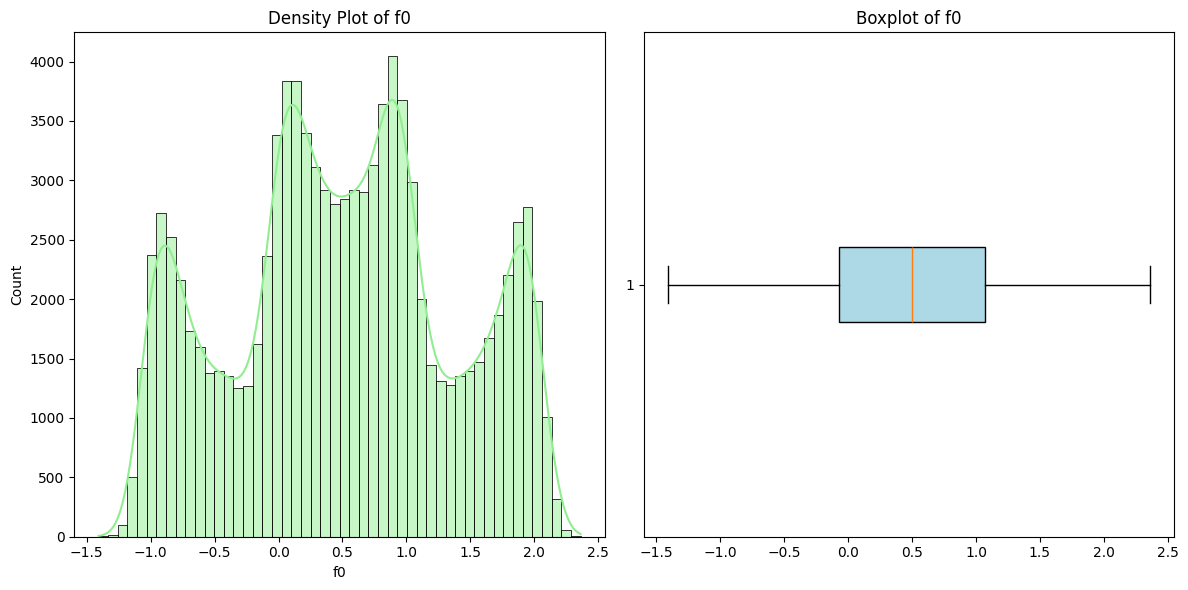

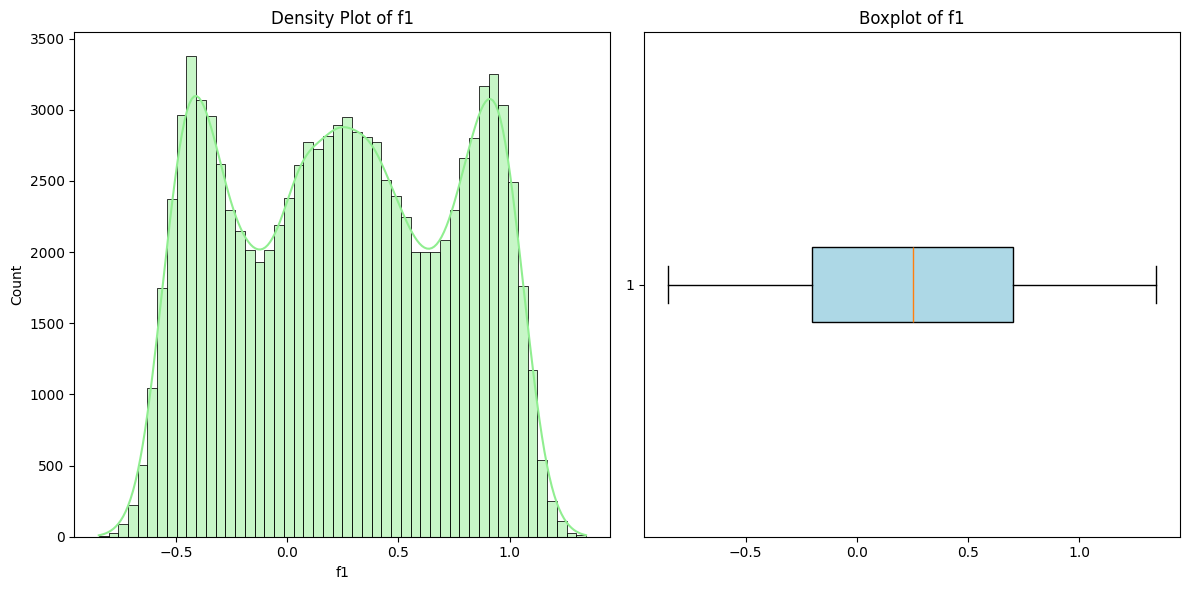

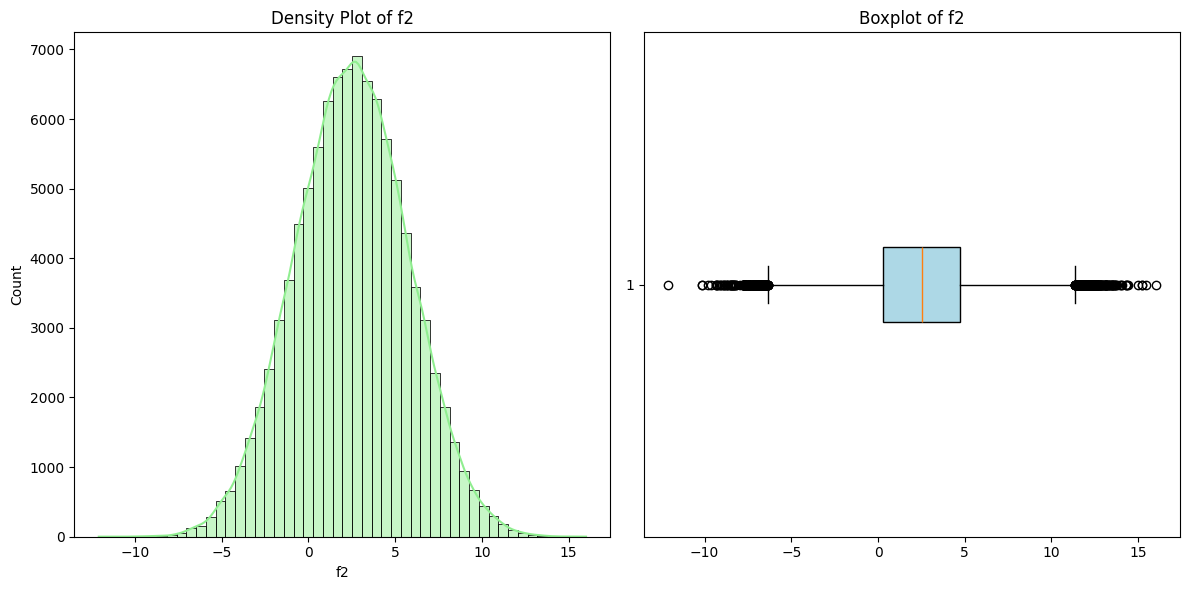

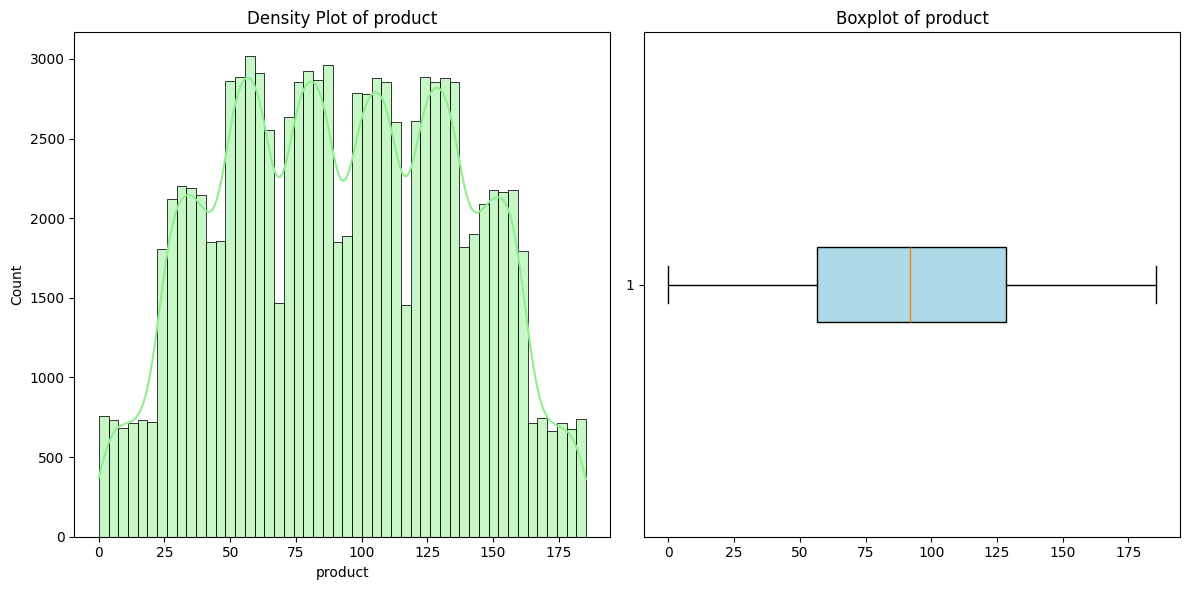

In [60]:
# Анализ распределения входных признаков и таргета в Регионе 1
for col in df_1.columns:
    plot_density_and_boxplot(df_1, col)

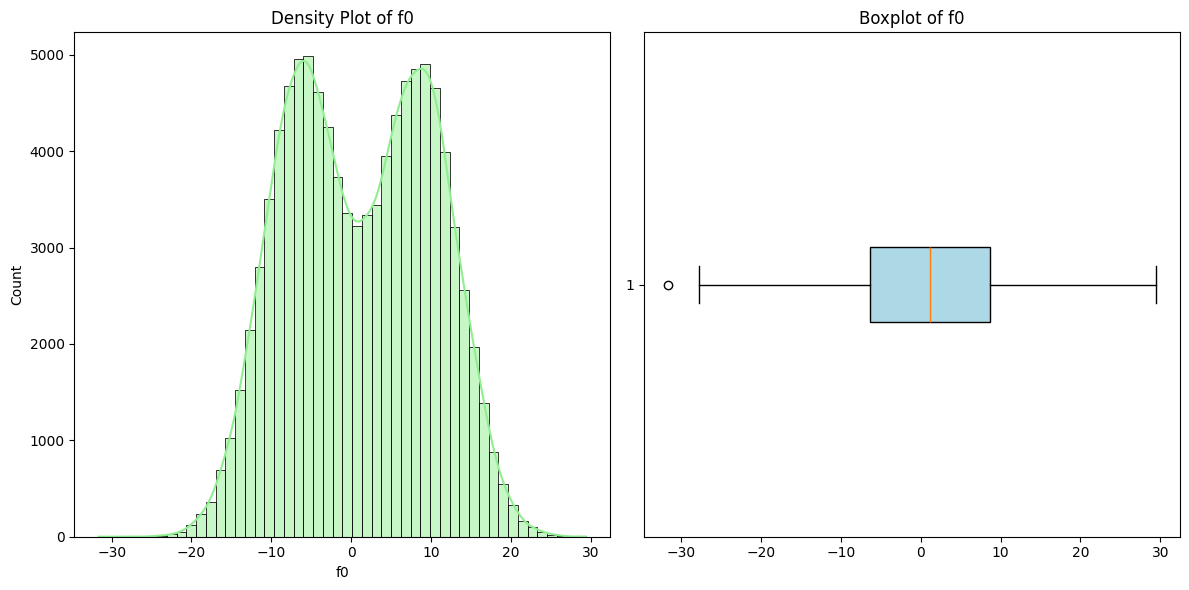

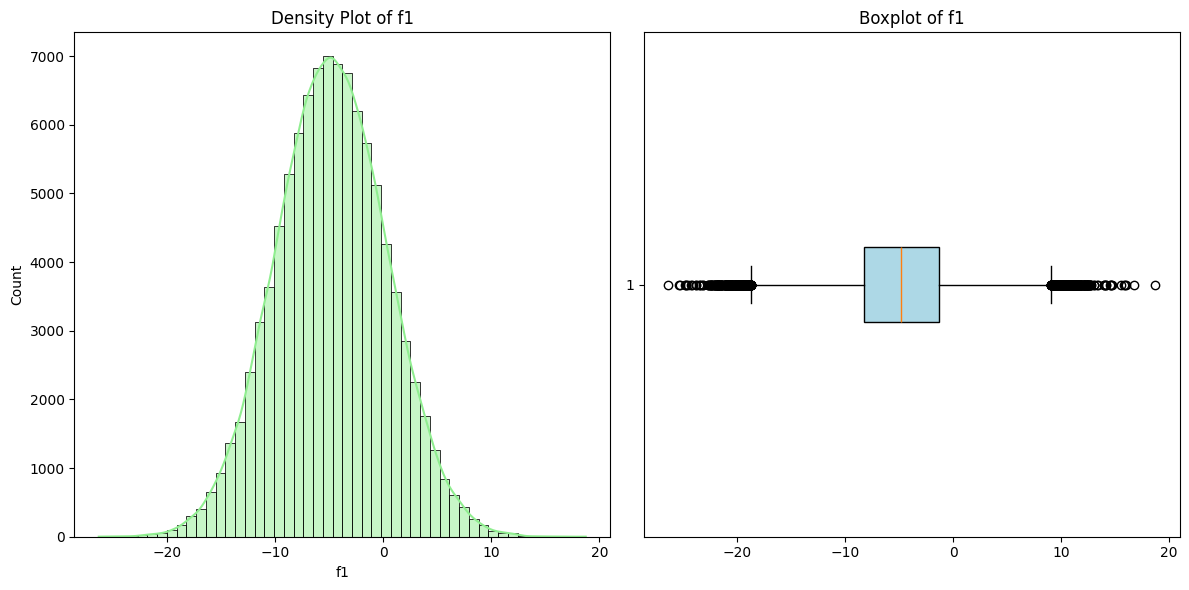

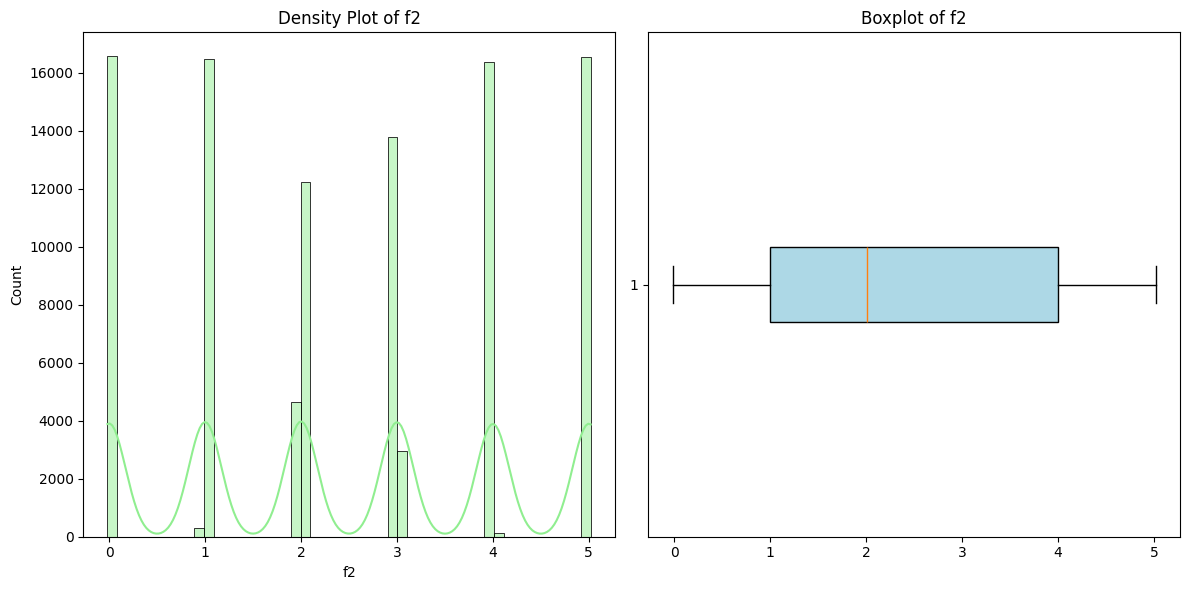

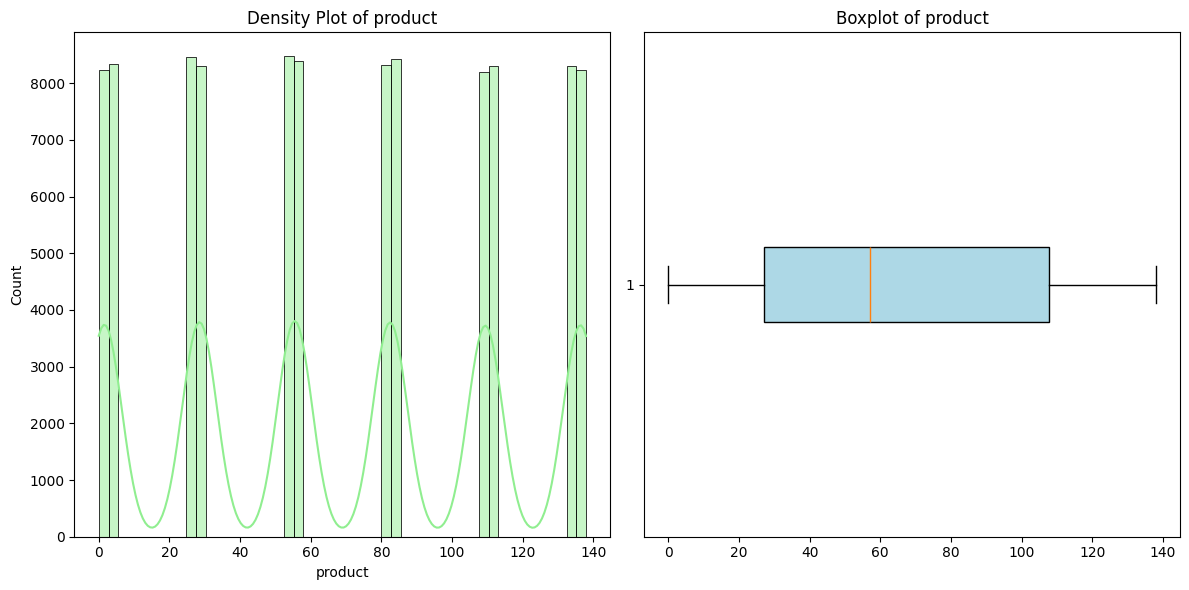

In [61]:
# Анализ распределения входных признаков и таргета в Регионе 2
for col in df_2.columns:
    plot_density_and_boxplot(df_2, col)

- Характер распределения признака f2 и таргета говорит о том, что эти признаки имеют дискретный характер.

In [62]:
# Проверка числа уникальных значений признака f2
len(df_2['f2'].unique())

100000

In [63]:
# Проверка числа уникальных значений таргета
len(df_2['product'].unique())

12

In [64]:
df_2['product'].unique()

array([  3.17910258,  26.95326103, 134.76630516, 137.94540774,
        84.03888568, 110.99214671,  53.90652206,   0.        ,
       107.81304413,  57.08562465,  30.13236361,  80.85978309])

- Целевой признак принимает всего 12 уникальных значений.
- Входной признак f2 принимает 100000 уникальных значений, однако распределение очень сильно отличается от распределения такого же признака для Региона 1.

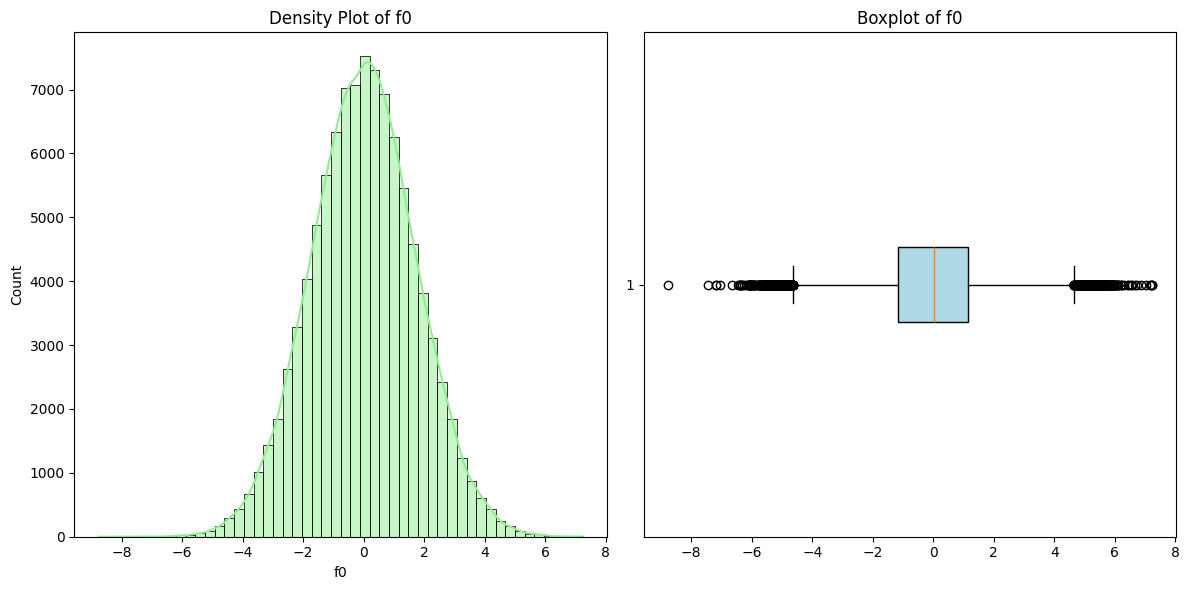

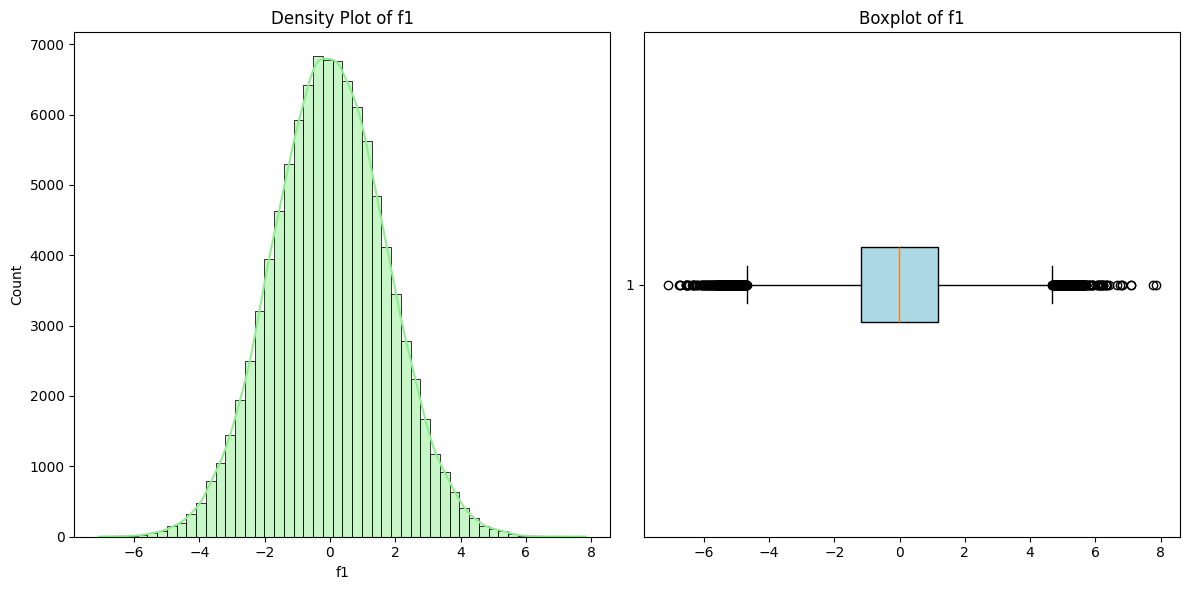

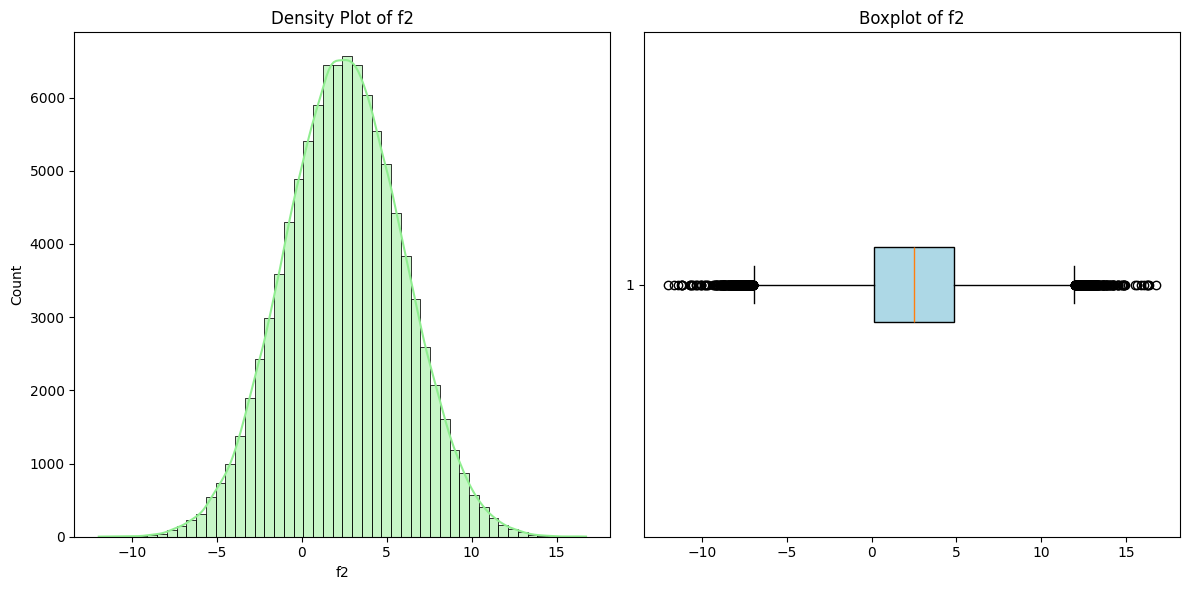

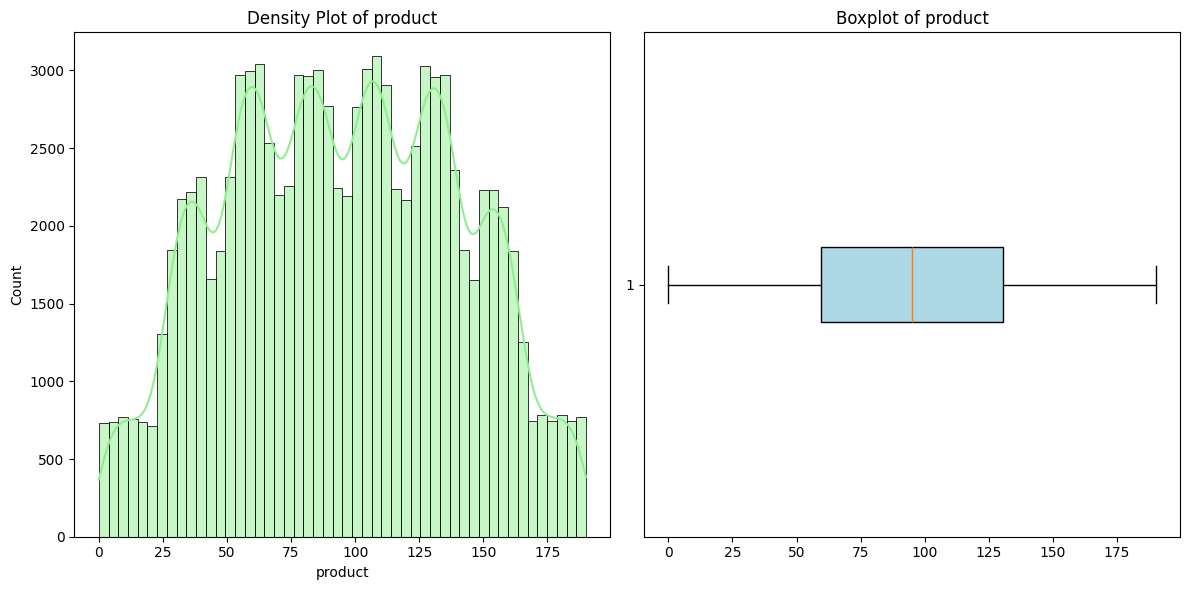

In [65]:
# Анализ распределения входных признаков и таргета в Регионе 3
for col in df_3.columns:
    plot_density_and_boxplot(df_3, col)

- Распределения признака f0 симметричные, однако имеет форму нормального только для Региона 3, в Регионах 1,2 имеет ярко выраженные пики.
- Распределения признака f1 симметричные, имеют форму нормального для Регионов 2,3, в Регионе 1 имеет пики.
- Распределение признака f2 в Регионе 2 имеет сильное отличие от распределения в Регионах 1,3. значения, похожи на дискретные.
- Распределение таргета также сильно отличается для Региона 2.
- Боксплоты имеют значения выходящие за границы "усов", однако, нельзя утверждать, что такие значения являются аномалиями.

Стоит обратить внимание Заказчика на данные по Региону 2, вероятно проблема в данных связана с проблемами в измерительном оборудовании, которое использовалось во втором регионе.

### 2.4 Корреляционный анализ

In [66]:
# Матрица корреляции признаков в Регионе 1
phik_matrix(df_1, interval_cols=['f0', 'f1', 'f2', 'product'])

,f0,f1,f2,product
f0,1.00,0.76,0.00,0.22
f1,0.76,1.00,0.00,0.25
f2,0.00,0.00,1.00,0.48
product,0.22,0.25,0.48,1.00


In [67]:
# Матрица корреляции признаков в Регионе 2
phik_matrix(df_2, interval_cols=['f0', 'f1', 'f2', 'product'])

,f0,f1,f2,product
f0,1.00,0.20,0.00,0.63
f1,0.20,1.00,0.00,0.19
f2,0.00,0.00,1.00,0.98
product,0.63,0.19,0.98,1.00


In [68]:
# Матрица корреляции признаков в Регионе 3
phik_matrix(df_3, interval_cols=['f0', 'f1', 'f2', 'product'])

,f0,f1,f2,product
f0,1.00,0.00,0.00,0.20
f1,0.00,1.00,0.00,0.22
f2,0.00,0.00,1.00,0.44
product,0.20,0.22,0.44,1.00


- Отмечается крайне высокая корреляция таргета с признаком f2 в Регионе 2.
- Однако, как указано выше в п. 2.3, вероятно, это связано с особенностью данных в Регионе 2.
- В целом, мультиколлинеарности не наблюдается.

Данные готовы для моделирования.

## 3. Построение моделей МО

In [69]:
# Функция для обучения и оценки модели линейной регрессии

def train_evaluate(df):
    
    # Разделение на выборки
    X_train, X_test, y_train, y_test = train_test_split(
    df.drop('product', axis=1),
    df['product'], 
    test_size=0.25, 
    random_state=RANDOM_STATE
)

    print(f'Размер тренировочной выборки: {X_train.shape}')
    print(f'Размер тренировочной выборки: {X_test.shape}')

    # Обучение модели линейной регрессии на тренировочных данных
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Получение предсказаний модели
    y_pred = model.predict(X_test)

    # Преобразование массива предсказаний в серию
    y_pred = pd.Series(y_pred)

    # Расчёт среднего значения предсказанного запаса сырья
    product_mean = y_pred.mean()

    # Расчёт квадратного корня из среднеквадратичной ошибки
    rmse = root_mean_squared_error(y_test, y_pred)

    # Сброс индекса целевых значений
    y_true = y_test.reset_index(drop=True)

    # Вывод значений
    print(f'Первое значение предсказанного таргета: {y_pred[1]}') 
    print(f'Первое значение реального таргета: {y_true[1]}')
    print(f'Предсказанный средний запас сырья: {product_mean:,.2f} тыс. баррелей')
    print(f'Модель ошибается в среднем на: {rmse:,.2f} тыс. баррелей')

    return y_pred, y_true

In [70]:
# Регион 1
y_pred_1, y_true_1 = train_evaluate(df_1)

Размер тренировочной выборки: (75000, 3)
Размер тренировочной выборки: (25000, 3)
Первое значение предсказанного таргета: 95.09840739760072
Первое значение реального таргета: 10.583795291374258
Предсказанный средний запас сырья: 92.27 тыс. баррелей
Модель ошибается в среднем на: 37.48 тыс. баррелей


In [71]:
# Регион 2
y_pred_2, y_true_2 = train_evaluate(df_2)

Размер тренировочной выборки: (75000, 3)
Размер тренировочной выборки: (25000, 3)
Первое значение предсказанного таргета: 137.03155518222445
Первое значение реального таргета: 137.94540774090564
Предсказанный средний запас сырья: 69.15 тыс. баррелей
Модель ошибается в среднем на: 0.89 тыс. баррелей


In [72]:
# Регион 3
y_pred_3, y_true_3 = train_evaluate(df_3)

Размер тренировочной выборки: (75000, 3)
Размер тренировочной выборки: (25000, 3)
Первое значение предсказанного таргета: 59.94815850435204
Первое значение реального таргета: 61.28574385362076
Предсказанный средний запас сырья: 94.71 тыс. баррелей
Модель ошибается в среднем на: 40.31 тыс. баррелей


- По вышеприведённым данным, наибольший объём запасов сырья ожидается в скважинах Региона 3. Однако, модель для Региона 3 имеет наибольшую погрешность.
- Модель для Региона 2 имеет наименьшую погрешность. Однако, стоит принять во внимание, что распределения признака f2 и таргета в значительной степени отличаются от распределений этих признаков для скважин Региона 1 и 2. Вероятно, в данных есть неточности.

## 4. Расчёт прибыли

### 4.1 Расчёт достаточного объёма сырья для безубыточной разработки новой скважины

In [73]:
# Число исследуемых точек
n_locations = 500

# Число лучших скважин для разработки
n_wells = 200

# Бюджет на разработку скважин 10 млрд. руб.
expenses = 10 * 10**9 

# Доход с одной единицы объёма 450 тыс. руб.
profit_per_unit = 450 * 10**3

In [74]:
# Минимальная необходимая прибыль с одной скважины
min_profit_per_well = expenses / n_wells
print(f'Минимальная необходимая прибыль с одной скважины: {min_profit_per_well:,.2f}')

Минимальная необходимая прибыль с одной скважины: 50,000,000.00


In [75]:
# Минимальный необходимый объём запаса одной скважины
min_volume_product = min_profit_per_well / profit_per_unit
print(f'Минимальный необходимый объём запаса одной скважины: {min_volume_product:,.2f}')

Минимальный необходимый объём запаса одной скважины: 111.11


Таким образом:
- Минимальная необходимая прибыль для безубыточного производства с одной скважины должна составлять **50** млн. руб.
- При этом, минимальный объём запаса скважины должен составлять ориентировочно **111** тыс. баррелей, что выше средних значений запасов по всем трём регионам (**92.5, 68.8, 95.0** тыс. баррелей для Регионов 1,2,3 соответственно).

### 4.2 Расчёт прибыли по выбранным скважинам и предсказаниям модели

#### 4.2.1 Функция для расчёта прибыли

In [76]:
# Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

def calculate_profit(y_pred, y_true, num):
    # Сортировка предсказанных объёмов в порядке убывания и получение их индексов
    y_pred_sorted = y_pred.sort_values(ascending=False).index
    
    # Выбор истинных значений объёмов для лучших предсказаний (top num скважин)
    y_true_top = y_true[y_pred_sorted].head(num)
    
    # Расчёт валовой прибыли
    gross_profit = y_true_top.sum() * profit_per_unit
    
    # Расчёт чистой прибыли после вычета расходов
    net_profit = gross_profit - expenses
    
    return net_profit

#### 4.2.2 Расчёт прибыли по скважинам, выбранным на основе предсказаний моделей

В настоящем проекте для оценки ожидаемой прибыли и рисков по каждому региону применяется метод бутсреппинга, что позволит оценить статистические характеристики распределения прибыли по регионам без необходимости предположений о форме этого распределения. 

Основные цели бутстрепа в настоящем проекте:
- Вычисление ожидаемой средней прибыли.
- Определение 95%-го доверительного интервала для прибыли, что даст представление о диапазоне возможной прибыли с определённым уровнем уверенности.
- Оценка вероятности того, что прибыль будет отрицательная (убыток), что позволит оценить риск вложений в конкретный регион.

Принцип бутстрепа:
- Число итераций 1000.
- На каждой итерации случайным образом отбирается 500 скважин, что создаст подвыборку, которая имитирует процесс отбора скважин в реальных условиях.
- Для каждой подвыборки отбираются 200 скважин с самыми высокими показаниями прогнозов по запасу скважин.
- Для отобранных скважин рассчитывается чистая прибыль, доверительный интервал и вероятность убытков.

In [77]:
# Установка начального состояния генератора случайных чисел для воспроизводимости
state = np.random.RandomState(12345)

def bootstrap_profit(y_pred, y_true, n_iter=1000):
    
    # Список для хранения значений чистой прибыли
    net_profit_list = []

    for _ in range(n_iter):
        # Случайный выбор с возвратом 500 предсказанных значений
        y_pred_subsample = y_pred.sample(n=n_locations, replace=True, random_state=state)
        
        # Расчёт чистой прибыли для выбранных значений
        net_profit = calculate_profit(y_pred_subsample, y_true, num=n_wells)
        
        # Добавление значения чистой прибыли в список
        net_profit_list.append(net_profit)
        
    # Преобразование списка чистой прибыли в pandas.Series
    net_profit = pd.Series(net_profit_list)

    # Возврат среднего значения, нижней и верхней границ доверительного интервала и риска убытков
    return net_profit.mean(), net_profit.quantile(0.025), net_profit.quantile(0.975), (net_profit < 0).mean()


In [78]:
# Расчёт прибыли, доверительного интервала, риска по регионам

mean_profit_1, lower_1, upper_1, risk_1 = bootstrap_profit(y_pred_1, y_true_1)
mean_profit_2, lower_2, upper_2, risk_2 = bootstrap_profit(y_pred_2, y_true_2)
mean_profit_3, lower_3, upper_3, risk_3 = bootstrap_profit(y_pred_3, y_true_3)

print(f'Регион 1 - Средняя прибыль: {mean_profit_1:,.2f}, 95% CI: [{lower_1:,.2f}, {upper_1:,.2f}], Риск: {risk_1}')
print(f'Регион 2 - Средняя прибыль: {mean_profit_2:,.2f}, 95% CI: [{lower_2:,.2f}, {upper_2:,.2f}], Риск: {risk_2}')
print(f'Регион 3 - Средняя прибыль: {mean_profit_3:,.2f}, 95% CI: [{lower_3:,.2f}, {upper_3:,.2f}], Риск: {risk_3}')

Регион 1 - Средняя прибыль: 444,486,225.37, 95% CI: [-53,170,462.90, 949,296,653.19], Риск: 0.047
Регион 2 - Средняя прибыль: 491,573,277.28, 95% CI: [113,115,966.69, 870,932,298.86], Риск: 0.002
Регион 3 - Средняя прибыль: 388,914,311.31, 95% CI: [-147,014,174.38, 906,065,451.83], Риск: 0.077


Риск показывает долю выборок, в которых получена отрицательная прибыль. Если эта доля меньше 2.5% (или 0.025), то регион считается приемлемым для разработки, поскольку риск убытков находится в допустимых пределах.

Таким образом, по результатам представленных расчётов Регион 2 имеет самый высокий показатель ожидаемого дохода (479,779,877.92 рублей) и наименьший риск (1.2%).

**Выводы и рекомендации для Заказчика:**

В вышеприведённом проекте были осуществлены:
- анализ данных Заказчика (характеристики проб нефти из скважин в Регионах 1,2,3);
- создание моделей МО для предсказания объёма запаса нефти в новых скважинах по каждому региону;
- анализ возможной прибыли и рисков техникой Bootstrap.

Из результатов расчётов и анализа следует, что наиболее благоприятные прогнозы для принятия решения об инвестировании средств в разработку скважин имеются по Региону 2. 

Средняя прибыль в Регионе 2 с 95% вероятностью будет принимать минимальное значение в 82,432,789.00 рублей и максимальное - в 882,286,878.40 рублей. 

При этом риск получения убытков составит 1.2%.

Однако, отмечается, что исходные данные, представленные Заказчиком для Региона 2 вероятно содержат ошибки (см. п. 2.3. настоящего отчёта), что могло повлиять на качество предсказаний. 

Рекомендуется перепроверить данные по Региону 2, и при отсутствии ошибок, Регион 2 может быть рекомендован Заказчику в качестве локации для разработки новой скважины.